In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import skops.io as sio
import os

In [33]:
# Charger les données
df = pd.read_csv("Data/data.csv")

# Supprimer la dernière colonne inutile
df = df.drop(columns=["Unnamed: 32"])

# Afficher les 5 premières lignes
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [34]:
# Séparer features / target
X = df.drop(columns=["diagnosis"])  # colonne cible
y = df["diagnosis"]

# Garder un DataFrame pour X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=125)

In [35]:
# Identifier colonnes numériques et catégorielles
num_cols = X_train.select_dtypes(include="number").columns.tolist()
cat_cols = X_train.select_dtypes(include="object").columns.tolist()

In [36]:
# Préprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", OrdinalEncoder(), cat_cols)
    ]
)

# Pipeline complet
pipe = Pipeline([
    ("preprocessing", preprocess),
    ("model", RandomForestClassifier(n_estimators=10, random_state=125))
])

# Entraîner le modèle
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['id', 'radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                                   'radius...
                                                   'compactness_se',
                                                   'concavity_se',
                                                   'concave points_se',
                                                   'symmetry_se',
                                                   'fractal_dimension_se',
                                                   'radius_worst',
                                                   'texture_worst',
                                                   'perimeter_worst',
                                                   'area_worst',
                                                   'smoothness_worst',
                                                   'compactness_worst',
                                                   'concavity_worst',
                                                   'concave points_worst',
                                                   'symmetry_worst', ...]),
                                                 ('cat', OrdinalEncoder(),
                                                  [])])),
                ('model',
                 RandomForestClassifier(n_estimators=10, random_state=125))])

In [37]:
from sklearn.metrics import accuracy_score, f1_score

# Faire les prédictions
predictions = pipe.predict(X_test)

# Calcul des métriques
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions, average="macro")

print("Accuracy:", str(round(accuracy * 100, 2)) + "%", "| F1:", round(f1, 2))

Accuracy: 95.32% | F1: 0.95


In [38]:
with open("Results/metrics.txt", "w") as outfile:
    outfile.write(
        f"Model evaluation on Breast Cancer dataset:\n"
        f"- Accuracy: {round(accuracy, 2)}\n"
        f"- F1 Score: {round(f1, 2)}\n"
    )


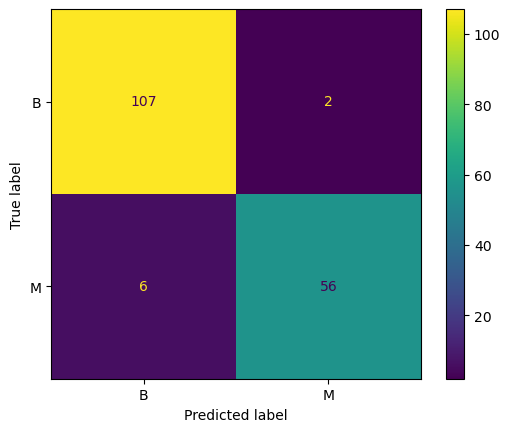

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Prédictions
predictions = pipe.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, predictions, labels=pipe.classes_)

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
disp.plot()

# Sauvegarde
plt.savefig("Results/model_results.png", dpi=120)

In [40]:
!pip install skops

In [41]:
# Sauvegarder le pipeline avec skops
sio.dump(pipe, "Model/breast_cancer_pipeline.skops")